<a href="https://colab.research.google.com/github/RipeMangoBox/STARRY/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1 - Configuration Setup

In [574]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from torchvision import datasets, transforms
from typing import List, Callable, Union, Any, TypeVar, Tuple
from sklearn.manifold import TSNE
import pandas as pd




# Step 2 - VAE Model

## VGG_Encoder

In [575]:
# 仅定义一个 3x3 的池化层窗口
m = nn.MaxPool2d(kernel_size=(2, 2))

# 定义输入
# 四个参数分别表示 (batch_size, C_in, H_in, W_in)
# 分别对应，批处理大小，输入通道数，图像高度（像素），图像宽度（像素）
# 为了简化表示，我们只模拟单张图片输入，单通道图片，图片大小是6x6
input = torch.randn(1, 1, 10, 6)

print(input)

output = m(input)

print(output.shape)


tensor([[[[-0.6896,  1.4521, -0.7920, -0.7861,  0.4012, -2.2192],
          [ 0.2928, -0.0617,  1.1409, -1.7748, -1.3502, -0.3760],
          [-0.9041,  0.9180,  0.3067,  1.6348,  1.2840, -1.5681],
          [ 0.0593, -0.3097,  1.6613, -0.9938,  2.1051, -0.3890],
          [ 0.3139, -1.4942, -0.1224,  0.4005,  0.9223, -0.5975],
          [ 0.7272, -0.8449,  0.9384, -0.5104, -0.4843, -0.2168],
          [ 0.6394, -1.9211, -0.7945,  1.1830, -1.0478,  0.8198],
          [ 0.5533, -1.9759, -0.7436, -0.7320, -0.1924, -0.2825],
          [-0.8458, -0.8354,  1.8759,  0.2630, -0.0685,  0.0131],
          [ 0.4741,  0.4239, -1.8703,  0.3264, -1.3774, -1.3600]]]])
torch.Size([1, 1, 5, 3])


In [576]:
'''VGG11/13/16/19 in Pytorch.'''

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, 
                 vgg_name='VGG19',
                 latent_dim=64,
                 input_channels: int = 1):
        super(VGG, self).__init__()
        self.input_channels = input_channels
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        self.latent_dim = latent_dim
        # self.MLP = nn.Linear(512, 512) # 不如不加

        self.mu = nn.Linear(512, self.latent_dim)
        self.log_var = nn.Linear(512, self.latent_dim)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        # out = self.classifier(out)

        # out = self.MLP(out)
        mu = self.mu(out)
        log_vars = self.log_var(out)

        return mu, log_vars

    def _make_layers(self, cfg):
        layers = []
        in_channels = self.input_channels
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def test():
    input_channels = 3
    image_size = 32
    net = VGG('VGG19', latent_dim=64, input_channels=input_channels)
    x = torch.randn(2,input_channels,image_size,image_size)
    mu, log_var = net(x)
    print(mu.shape, log_var.shape)

test()

torch.Size([2, 64]) torch.Size([2, 64])


## Linear_Encoder

In [577]:
class Linear_Encoder(nn.Module):
    def __init__(self,
                 image_size: int,
                 layer_sizes: List,
                 latent_dim: int,
                 input_channels: int = 1):
        super().__init__()
        
        self.input_channels = input_channels
        self.layer_sizes = layer_sizes.copy()
        self.image_size = image_size
        self.MLP = nn.Sequential()

        for i, (in_size, out_size) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())

        self.mu = nn.Linear(self.layer_sizes[-1], latent_dim)
        self.log_var = nn.Linear(self.layer_sizes[-1], latent_dim)


    def forward(self, x):
        x = x.view(-1, self.input_channels * self.image_size * self.image_size)
        x = self.MLP(x)
        mu = self.mu(x)
        log_vars = self.log_var(x)

        return mu, log_vars
    
def test():
    x = torch.randn(6, 3, 32, 32)
    encoder = Linear_Encoder(32, [3*32*32, 512, 256, 128], 64, 3)
    mu, log_var = encoder(x)
    print(mu.shape, log_var.shape)

test()

torch.Size([6, 64]) torch.Size([6, 64])


In [578]:
class Encoder(nn.Module):
    def __init__(self,
                 image_size: int,
                 layer_sizes: List,
                 latent_dim: int,
                 input_channels: int = 1,
                 use_VGG: bool = False):
        super().__init__()

        if use_VGG == False:
            self.MLP = Linear_Encoder(image_size, layer_sizes, latent_dim, input_channels)
        else:
            self.MLP = VGG(latent_dim=latent_dim, input_channels=input_channels)

    def forward(self, x):
        mu, log_vars = self.MLP(x)
        return mu, log_vars

class Decoder(nn.Module):
    def __init__(self,
                 layer_sizes: List,
                 latent_dim: int,
                 output_channels: int = 1):
        super().__init__()

        self.MLP = nn.Sequential()
        self.output_channels = output_channels

        input_size = latent_dim

        for i, (in_size, out_size) in enumerate(zip([input_size] + layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.ReLU())
            else:
                self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z):
        x = self.MLP(z)

        return x
    
def test():
    z = torch.randn(6, 64)
    decoder = Decoder([32*32, 512, 256, 128], 64, 3)
    recon = decoder(z)
    print(recon.shape)

test()

torch.Size([6, 128])


In [579]:
class VAE(nn.Module):
  def __init__(self, 
               config: dict = None,
               use_VGG: bool = False):
    super(VAE, self).__init__()

    self.image_size = config.image_size
    self.input_dim = config.input_channel
    self.layer_sizes = config.layer_sizes
    self.fc_dim = config.fc_dim
    self.latent_dim = config.latent_dim

    self.beta = 1

    self.encoder = Encoder(self.image_size, self.layer_sizes, self.latent_dim, self.input_dim, use_VGG=use_VGG)
    self.decoder = Decoder(self.layer_sizes[::-1], self.latent_dim, self.input_dim)

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std

  def forward(self, x):
    mu, log_var = self.encoder(x)
    
    z = self.reparameterize(mu, log_var)
    # print(f'mu: {mu.shape}, log_var: {log_var.shape}')
    recon = self.decoder(z)
    return self.decoder(z), mu, log_var

  def calc_loss(self, x, recon_x, mu, log_var):
    # print(f'recon_x: {recon_x.shape}, x: {x.shape}')
    recons_loss = F.mse_loss(recon_x.view(-1, self.input_dim, self.image_size*self.image_size), x.view(-1, self.input_dim, self.image_size*self.image_size), reduction="sum").div(x.shape[0])
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu** 2 - log_var.exp(), dim = 1), dim = 0)
    return recons_loss + self.beta * kld_loss

# Step 3 - Training

In [580]:
def idx2onehot(idx, n):

    assert torch.max(idx).item() < n

    if idx.dim() == 1:
        idx = idx.unsqueeze(1)
    onehot = torch.zeros(idx.size(0), n).to(idx.device)
    onehot.scatter_(1, idx, 1)
    
    return onehot

In [581]:
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


In [582]:
MNIST_config = Config(
    image_size = 28,
    layer_sizes = [1*28*28, 256],
    fc_dim = 128,
    latent_dim = 64,
    batch_size = 128,
    epochs = 10,
    input_channel = 1,
)

CIFAR10_config = Config(
    image_size = 32,
    layer_sizes = [3*32*32, 512, 256, 128],
    fc_dim = 128,
    latent_dim = 64,
    batch_size = 128,
    epochs = 50,
    input_channel = 3,
)


transform=transforms.Compose([
    transforms.ToTensor()
])


In [583]:
DATASET_Opt = 'CIFAR10'

if DATASET_Opt == 'MNIST':
    args = MNIST_config
    dataset1 = datasets.MNIST('../data/', train=True, download=True,
                    transform=transform)
    dataset2 = datasets.MNIST('../data/', train=False,
                    transform=transform)
else:
    args = CIFAR10_config
    dataset1 = datasets.CIFAR10('../data/', train=True, download=True,
                    transform=transform)
    dataset2 = datasets.CIFAR10('../data/', train=False,
                    transform=transform)

# 超参
image_size, layer_sizes, fc_dim, latent_dim, batch_size, epochs, input_channel = vars(args).values()

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [584]:
model = VAE(args, use_VGG=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [585]:
print_freq = 200
for epoch in range(epochs):
    print("Start training epoch {}".format(epoch,))
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        recon, mu, log_var = model(images)
        loss = model.calc_loss(images, recon, mu, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i + 1) % print_freq == 0 or (i + 1) == len(train_loader):
            print("\t [{}/{}]: loss {}".format(i, len(train_loader), loss.item()))

Start training epoch 0
	 [199/391]: loss 141.44625854492188
	 [390/391]: loss 115.74003601074219
Start training epoch 1
	 [199/391]: loss 113.18701171875
	 [390/391]: loss 106.62998962402344
Start training epoch 2
	 [199/391]: loss 101.22154235839844
	 [390/391]: loss 110.12801361083984
Start training epoch 3
	 [199/391]: loss 94.9125747680664
	 [390/391]: loss 96.48236846923828
Start training epoch 4
	 [199/391]: loss 97.27685546875
	 [390/391]: loss 113.50704956054688
Start training epoch 5
	 [199/391]: loss 100.53872680664062
	 [390/391]: loss 96.4673843383789
Start training epoch 6
	 [199/391]: loss 98.83914184570312
	 [390/391]: loss 90.31239318847656
Start training epoch 7
	 [199/391]: loss 96.13257598876953
	 [390/391]: loss 90.2750015258789
Start training epoch 8
	 [199/391]: loss 86.00949096679688
	 [390/391]: loss 106.44698333740234
Start training epoch 9
	 [199/391]: loss 95.71769714355469
	 [390/391]: loss 95.55751037597656
Start training epoch 10
	 [199/391]: loss 94.10330

# Step 4 - Results

torch.Size([64, 3072])


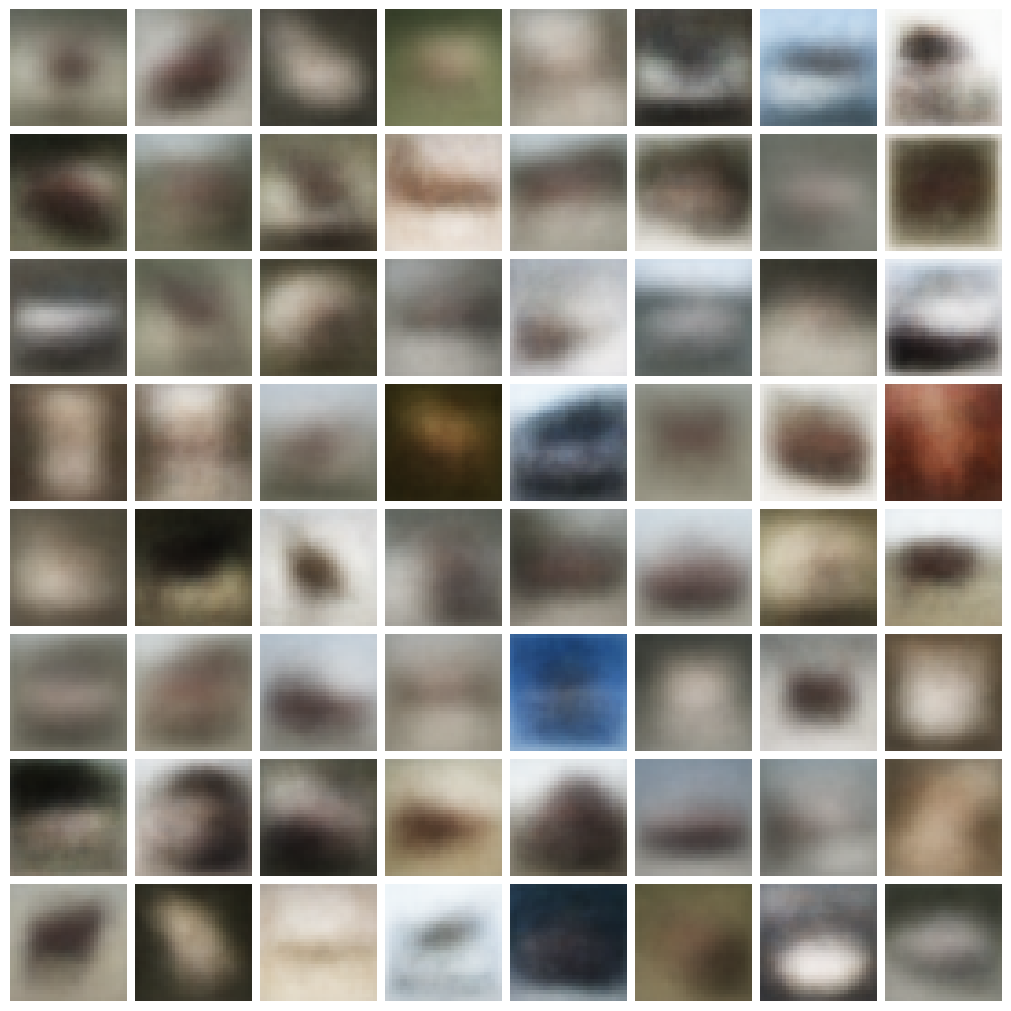

In [586]:
## generate new images by VAE

n_rows = 8
n_cols = 8

sample_zs = torch.randn(n_rows * n_cols, latent_dim).to(device)

model.eval()

with torch.no_grad():
    generated_imgs = model.decoder(sample_zs)
    print(generated_imgs.shape)
    
    generated_imgs = generated_imgs.cpu().numpy()

generated_imgs = np.array(generated_imgs * 255, dtype=np.uint8).reshape(n_rows, n_cols, input_channel, image_size, image_size)

fig = plt.figure(figsize=(10,  10), constrained_layout=True)
gs = fig.add_gridspec(n_rows, n_cols)

for n_row in range(n_rows):
    for n_col in range(n_cols):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        img = generated_imgs[n_row, n_col]  # 获取图像数据
        if DATASET_Opt == 'MNIST':
            f_ax.imshow(img.squeeze(), cmap='gray')  # 对于 MNIST，去除单通道维度
        else:  # 对于 CIFAR10 或其他 RGB 图像，保留通道维度放到最后
            f_ax.imshow(img.transpose(1, 2, 0))
        f_ax.axis("off")

plt.show()

# Step 5 - Visualization

In [587]:
def plot_latent_space_tsne(variable='mu', nums=1000):
  model.eval()
  with torch.no_grad():
    latent_vectors = []
    labels = []
    for data, label in test_loader:
      data = data.to(device)
      recon_x, mu, logvar = model(data)

      z = model.reparameterize(mu, logvar) if variable == 'z' else mu
      latent_vectors.append(z.cpu())
      labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0)[:nums]
    labels = torch.cat(labels, dim=0)[:nums]

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=2023)
    latent_tsne = tsne.fit_transform(latent_vectors)

    # Plot t-SNE
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(f't-SNE Visualization of Latent Space {variable}')
    plt.show()

### $\mu$的可视化

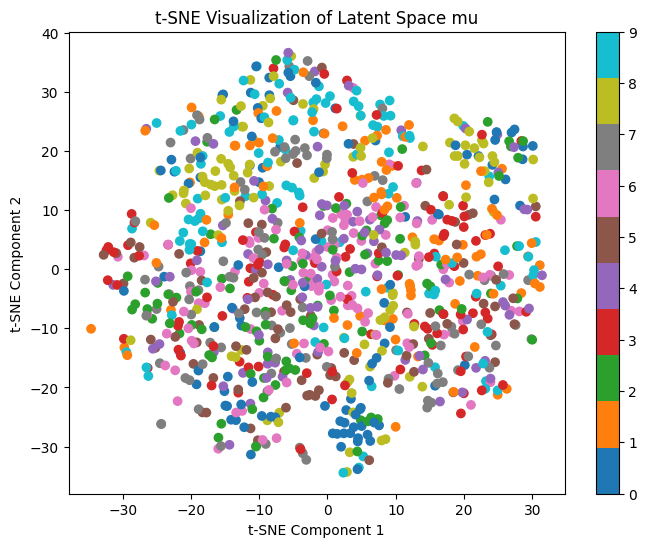

In [588]:
plot_latent_space_tsne('mu', 1000)

### z的可视化

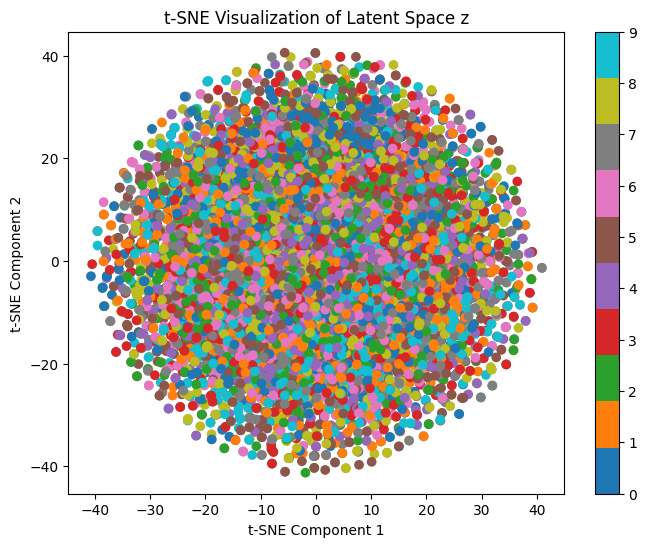

In [589]:
# 由于方差存在，z的可视化需要远比mu多的点才能看出效果
plot_latent_space_tsne('z', None)